In [88]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

In [89]:
df = pd.read_csv('earl694412-infinite-matchhistory-2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            518 non-null    object 
 1   Player          518 non-null    object 
 2   MatchId         518 non-null    object 
 3   Map             518 non-null    object 
 4   Category        518 non-null    object 
 5   Playlist        518 non-null    object 
 6   Input           518 non-null    object 
 7   Queue           518 non-null    object 
 8   Csr             518 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         518 non-null    object 
 11  Accuracy        518 non-null    float64
 12  DamageDone      518 non-null    int64  
 13  DamageTaken     518 non-null    int64  
 14  ShotsFired      518 non-null    int64  
 15  ShotsLanded     518 non-null    int64  
 16  ShotsMissed     518 non-null    int64  
 17  KD              518 non-null    flo

In [90]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['Csr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop('Playlist', axis=1).reset_index()
dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             315 non-null    int64         
 1   Date              315 non-null    datetime64[ns]
 2   Map               315 non-null    object        
 3   Category          315 non-null    object        
 4   Csr               315 non-null    int64         
 5   Outcome           315 non-null    int64         
 6   Accuracy          315 non-null    float64       
 7   DamageDone        315 non-null    int64         
 8   DamageTaken       315 non-null    int64         
 9   ShotsFired        315 non-null    int64         
 10  ShotsLanded       315 non-null    int64         
 11  ShotsMissed       315 non-null    int64         
 12  KD                315 non-null    float64       
 13  KDA               315 non-null    float64       
 14  Kills             315 non-

In [91]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,315.0,328.822222,108.096148,140.000000,243.500000,329.000000,424.500000,517.000000
Csr,315.0,945.834921,53.570164,790.000000,918.500000,952.000000,976.000000,1058.000000
Outcome,315.0,0.533333,0.499681,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,315.0,51.685429,5.704552,24.390000,48.570000,51.960000,54.640000,80.560000
DamageDone,315.0,5045.190476,1812.389893,347.000000,3784.000000,4729.000000,6170.500000,12673.000000
DamageTaken,315.0,4317.914286,1509.896505,276.000000,3353.500000,4078.000000,5208.000000,9962.000000
ShotsFired,315.0,228.209524,78.365065,16.000000,177.500000,217.000000,284.500000,468.000000
ShotsLanded,315.0,117.876190,41.808030,4.000000,92.000000,111.000000,145.000000,281.000000
ShotsMissed,315.0,110.333333,39.850357,7.000000,83.000000,106.000000,136.000000,261.000000
KD,315.0,1.253048,0.653327,0.000000,0.880000,1.150000,1.455000,6.000000


In [92]:
dfr.Kills.sum()

4517

In [93]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

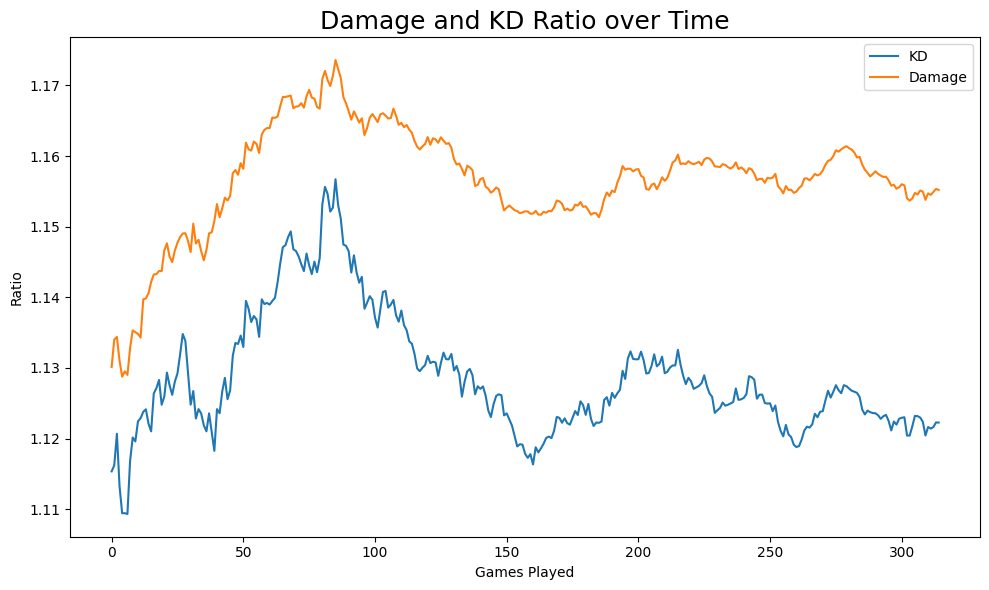

In [113]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

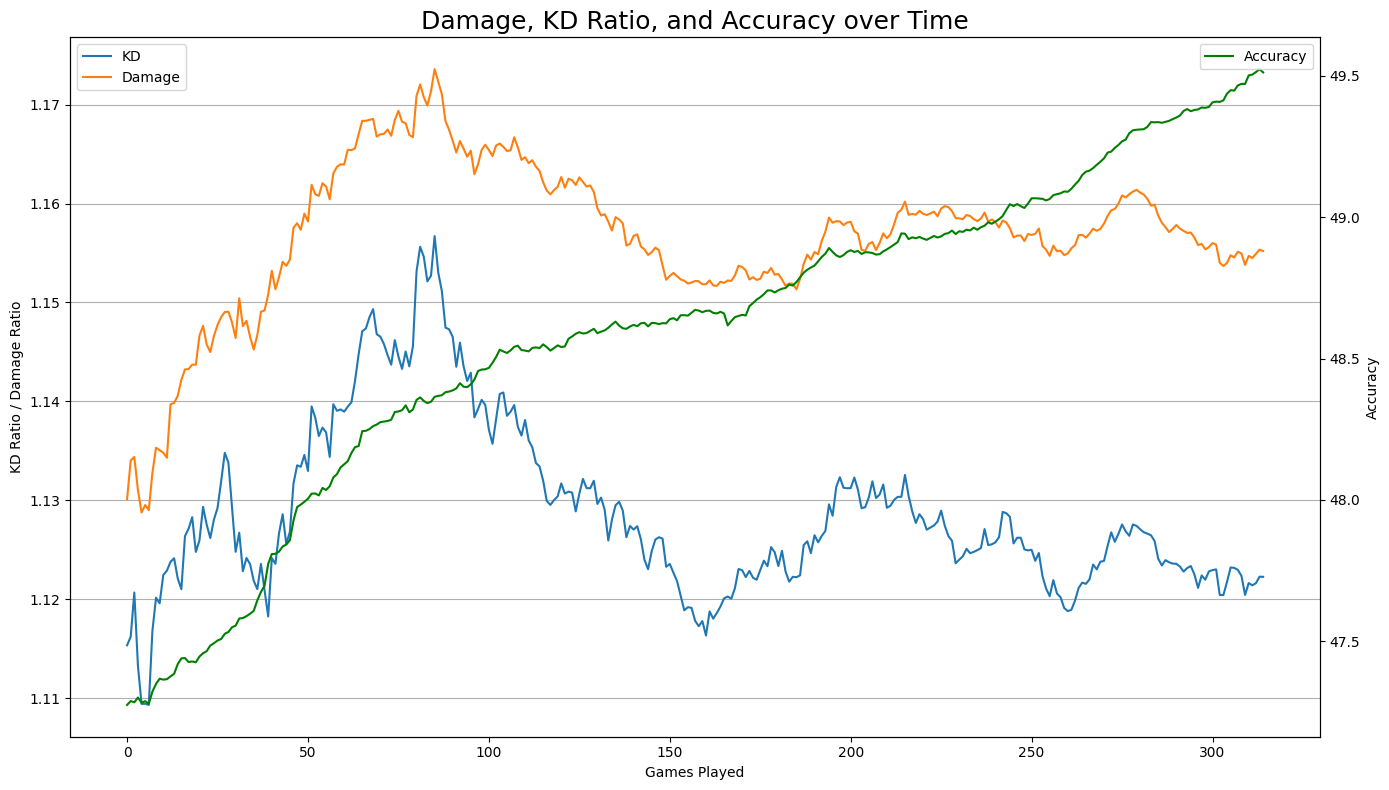

In [95]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax1.set_title('Damage, KD Ratio, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

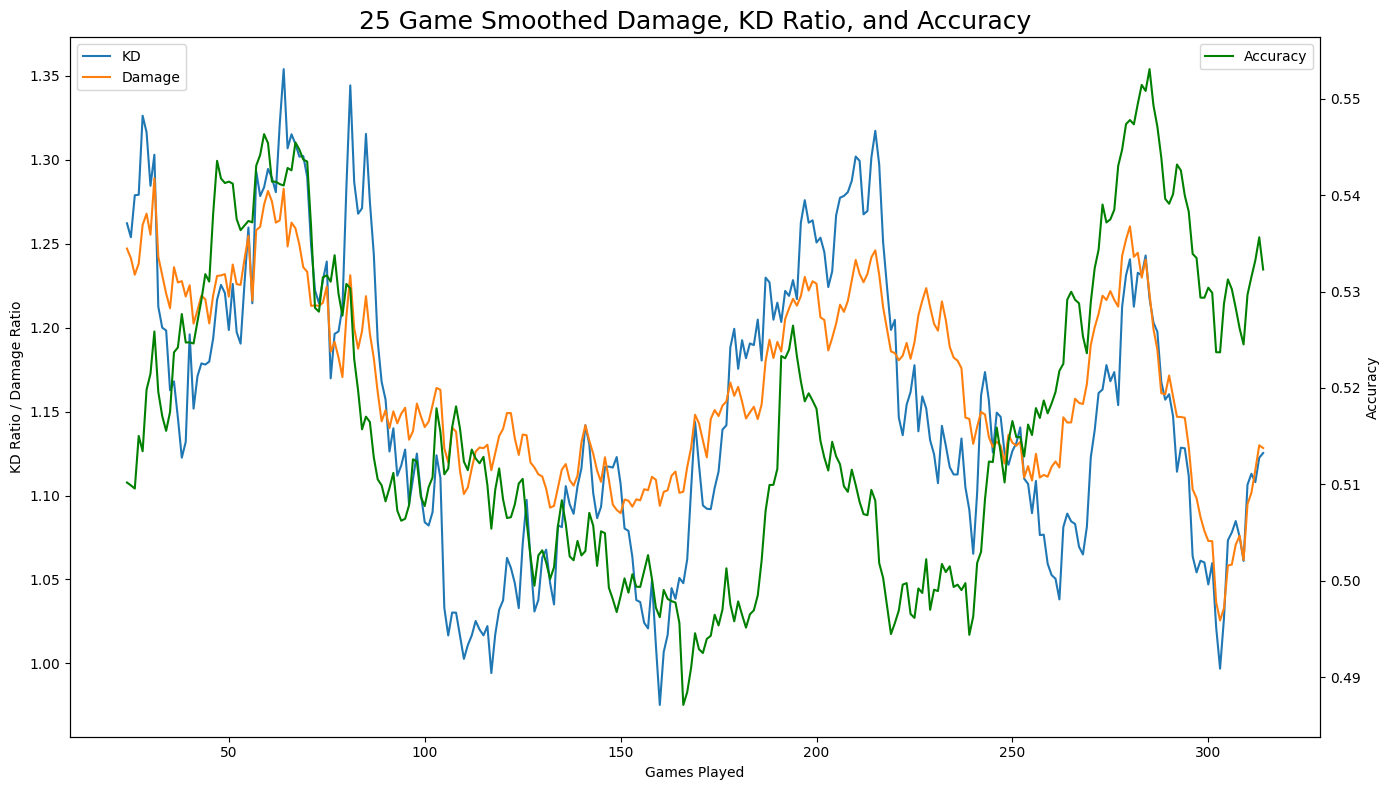

In [96]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum()
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

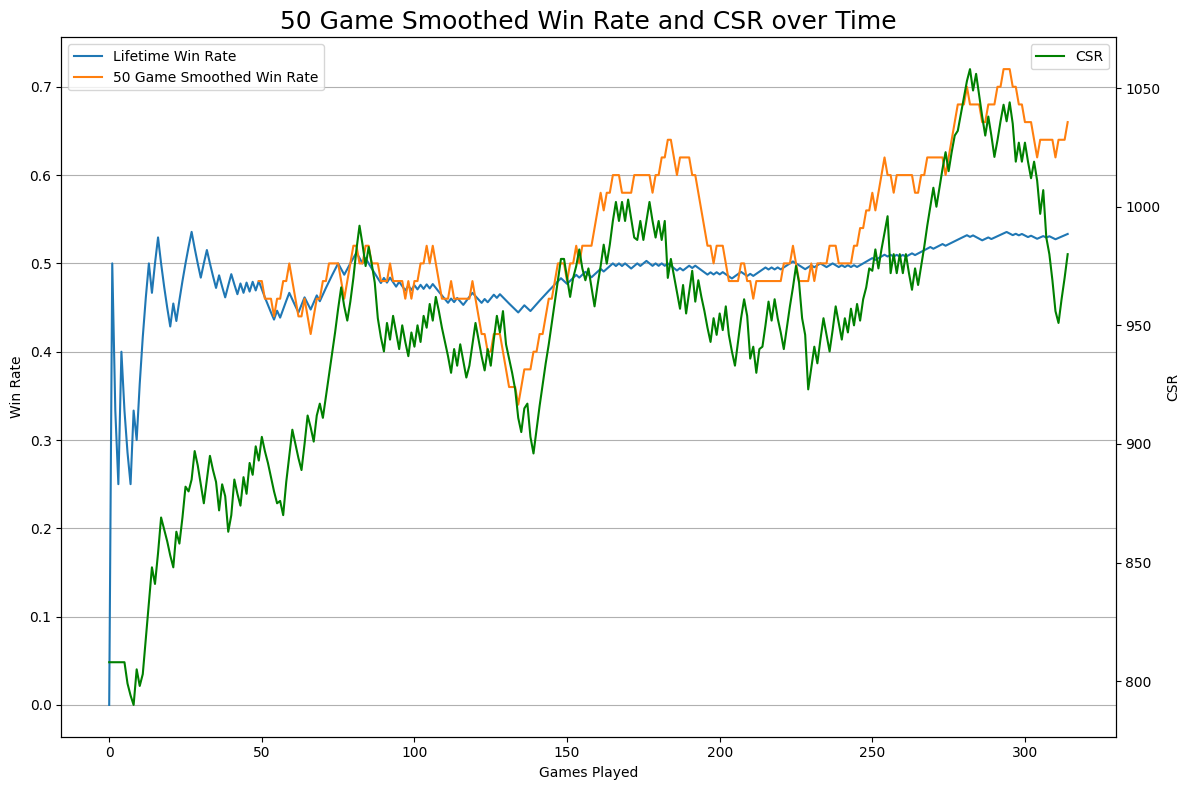

In [114]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

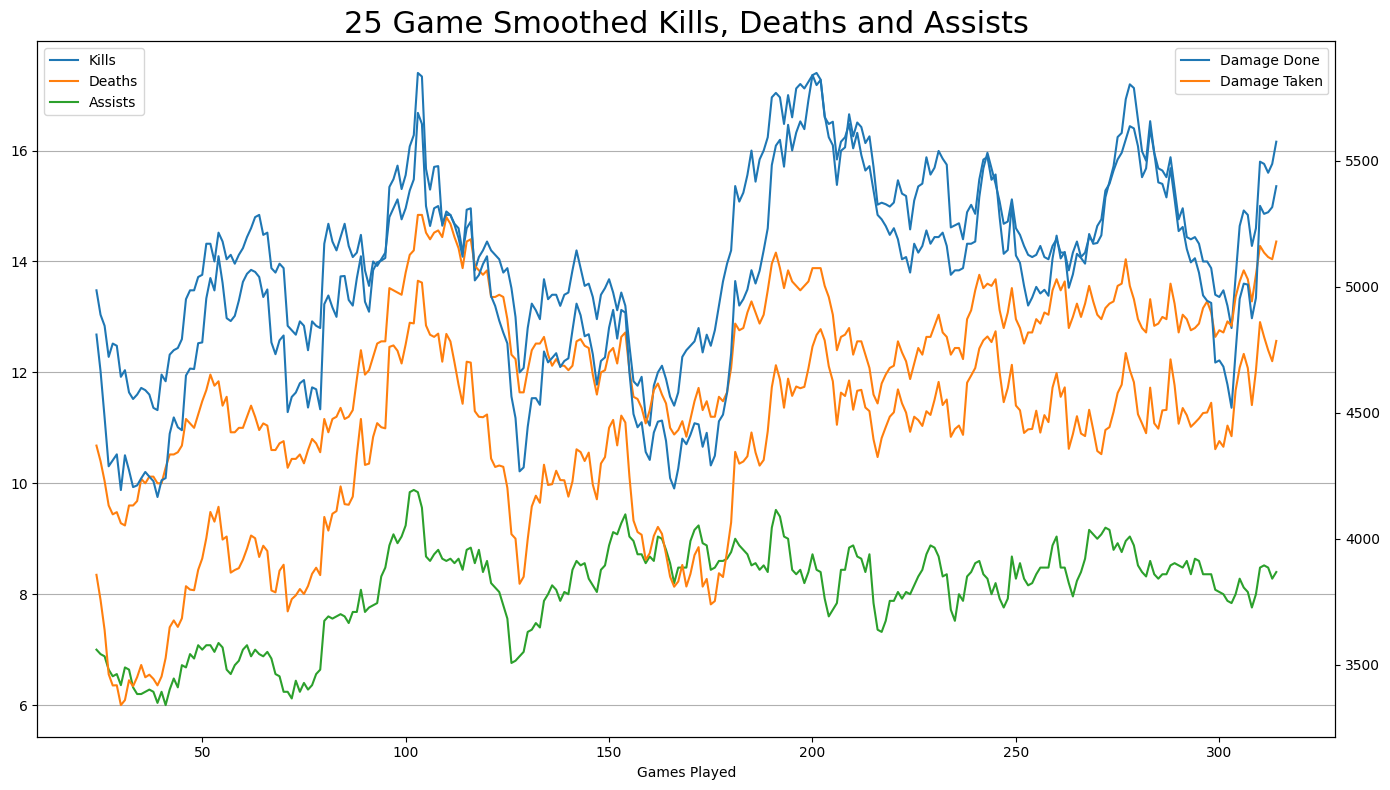

In [98]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

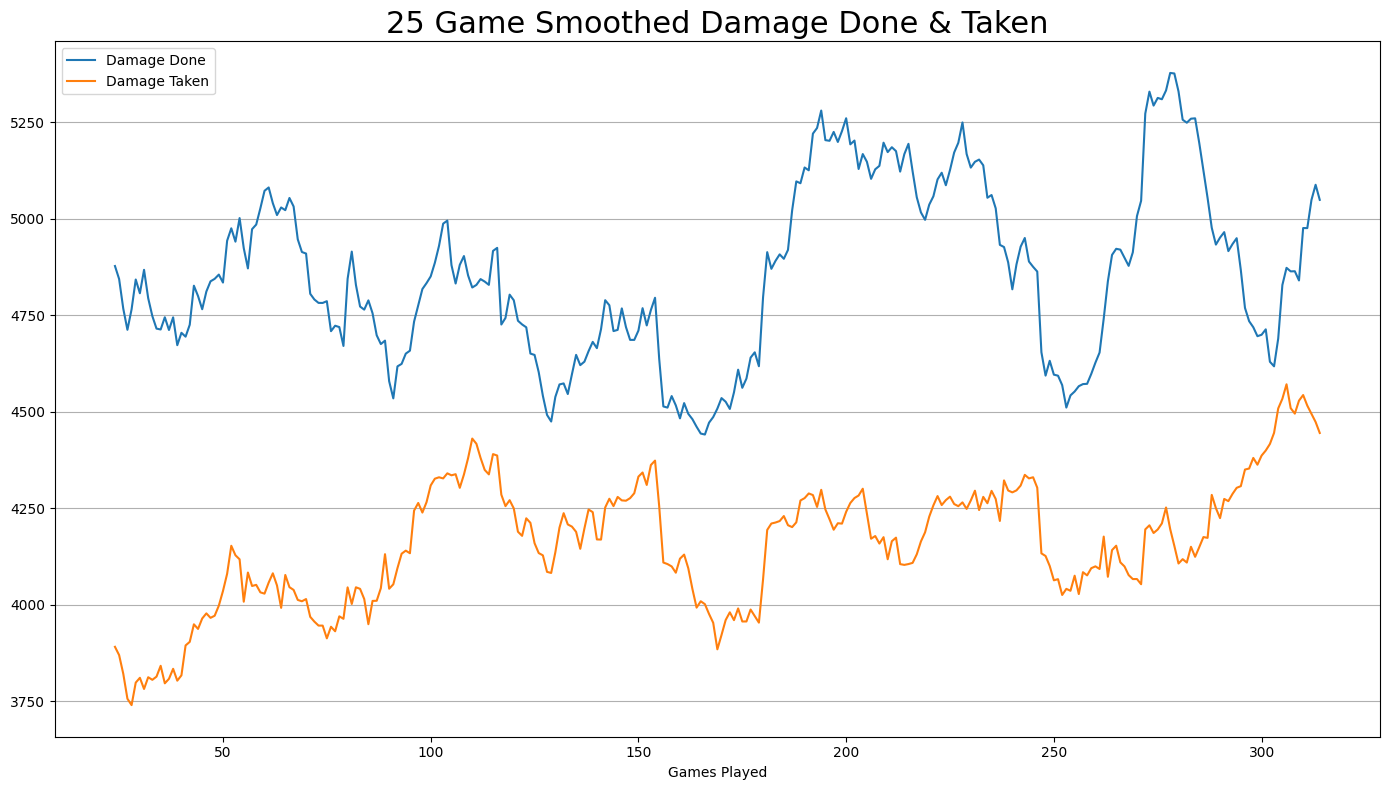

In [116]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

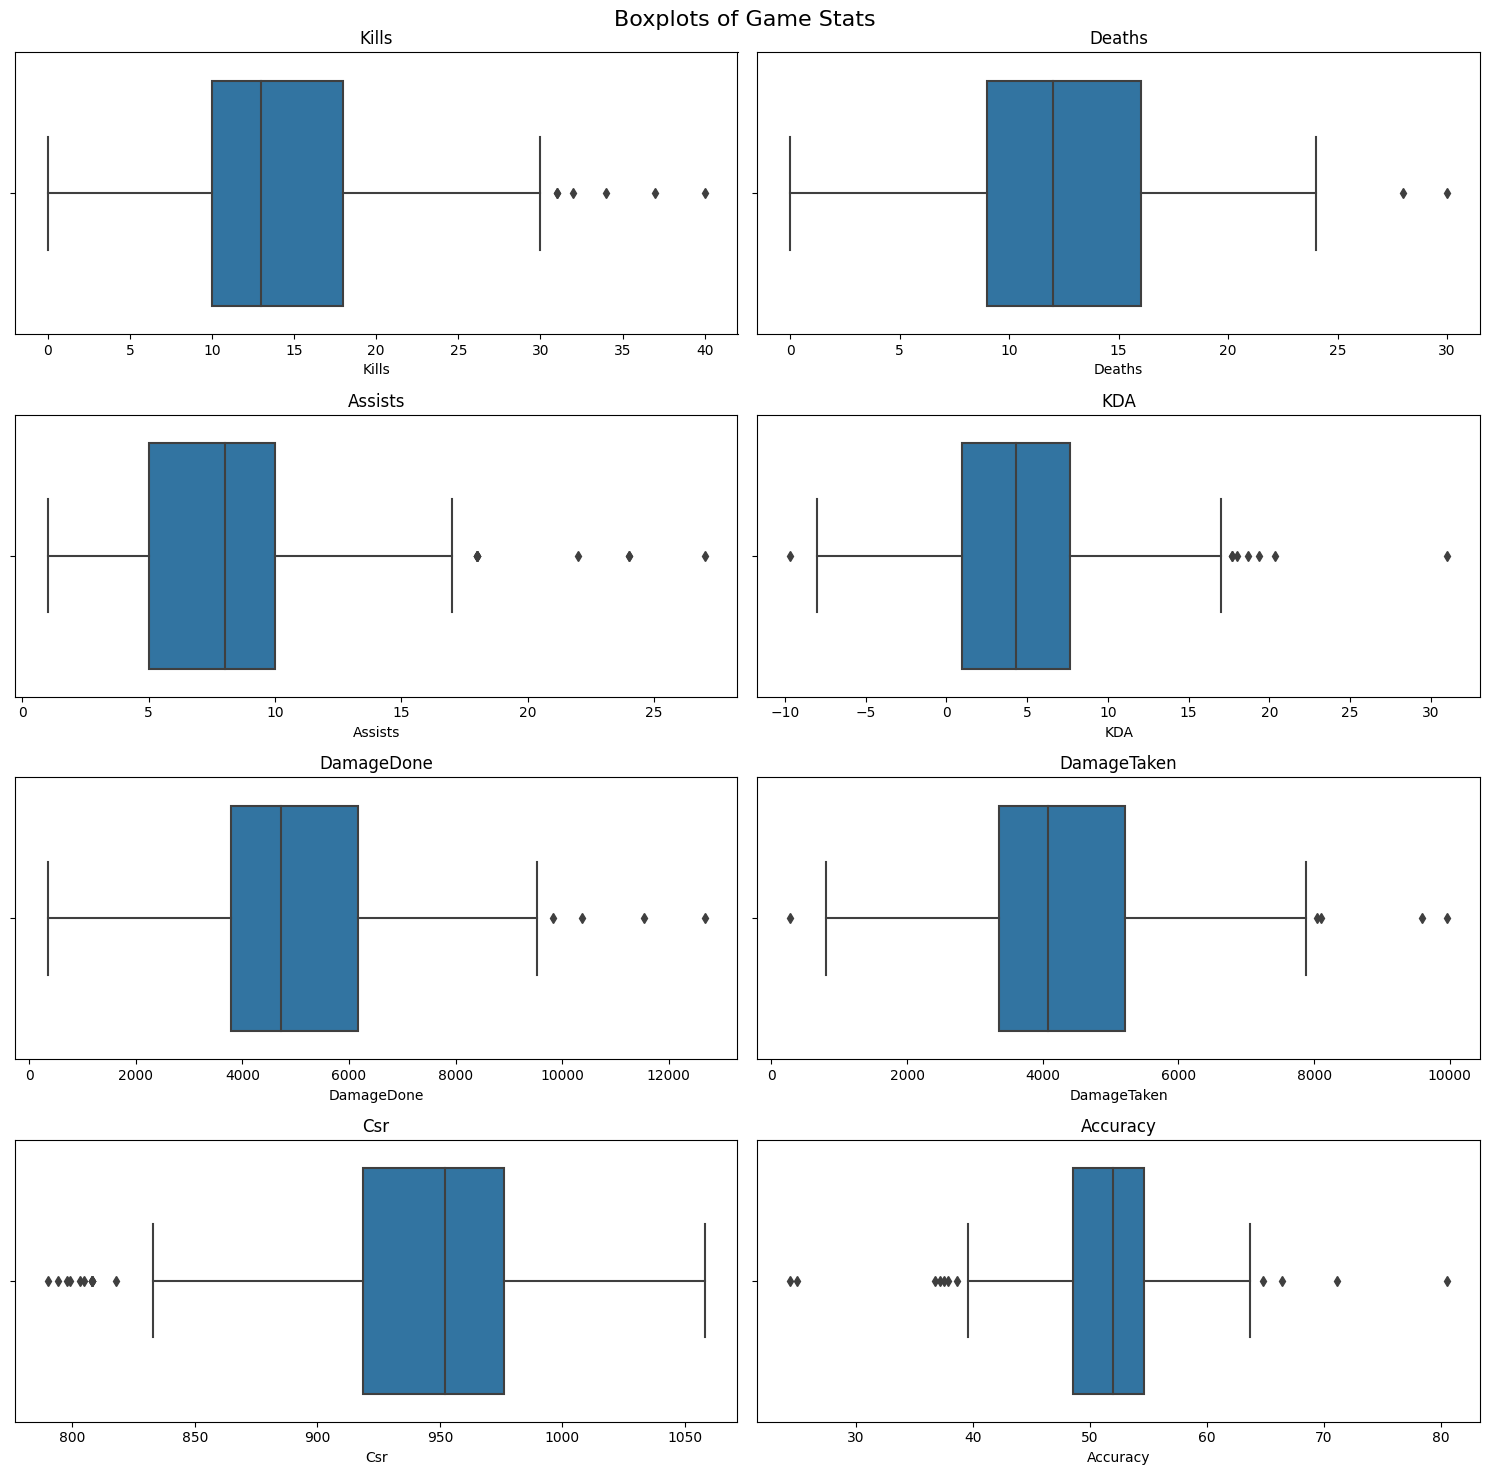

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [124]:
mod =25

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.13
Accuracy: 53.23
Damage Ratio: 1.13
Win-Loss: 15-10
Max CSR: 1044


In [102]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfw['Outcome']==1).sum()}-{(dfw['Outcome']==0).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfl['Outcome']==1).sum()}-{(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.15
Average Kills: 14.34
Average Deaths: 12.45
Average Damage Done: 5045
Average Damage Taken: 4318
Damage Ratio: 1.17
Win-Loss: 168-147
----------------------------
Wins
Overall KD: 1.28
Average Kills: 14.04
Average Deaths: 10.94
Average Damage Done: 4841
Average Damage Taken: 3970
Damage Ratio: 1.22
Win-Loss: 168-0
----------------------------
Losses
Overall KD: 1.04
Average Kills: 14.69
Average Deaths: 14.18
Average Damage Done: 5278
Average Damage Taken: 4715
Damage Ratio: 1.12
Win-Loss: 0-147


In [103]:
mapCatKD = dfr.pivot_table(index=['Map', 'Category'], 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapCatKD = mapCatKD.reindex(desired_col_order, axis=1)
mapCatKD = mapCatKD.round(2)

mapCatKD

Kills  Deaths    KD  Accuracy  DamageRatio  \
Map       Category                                                       
Aquarius  CTF 5 Captures    21.00   16.15  1.37     51.76         1.28   
          Slayer            11.15    9.19  1.30     51.36         1.22   
Argyle    CTF 3 Captures    13.38   12.38  1.14     49.33         1.19   
Empyrean  CTF 3 Captures    12.43   13.07  1.00     49.00         1.11   
Forbidden CTF 3 Captures    14.58    9.75  1.84     54.89         1.51   
Live Fire Extraction        12.31   10.54  1.30     55.22         1.20   
          King of the Hill  12.86   13.07  1.01     56.44         1.05   
          Oddball           14.54   14.77  1.10     50.60         1.20   
          Slayer            10.07    9.93  1.47     48.48         1.06   
          Strongholds       16.15   14.08  1.21     51.39         1.12   
Recharge  Extraction        13.00   11.00  1.41     52.49         1.29   
          King of the Hill  18.47   15.71  1.21     50.23         1.15   
          Oddball           17.33   13.78  1.23     49.34         1.17   
          Slayer             9.14    9.14  1.16     48.53         1.09   
          Strongholds       13.91   13.36  1.08     49.32         1.18   
Solitude  King of the Hill  21.11   13.78  1.79     52.28         1.33   
          Slayer            10.52   10.96  1.02     50.49         1.10   
          Strongholds       19.70   15.91  1.27     52.59         1.20   
Streets   Extraction        14.08   10.96  1.37     54.04         1.26   
          Oddball           16.85   15.20  1.16     53.87         1.20   
          Slayer             9.18    8.36  1.13     49.33         1.16   

                            Outcome  
Map       Category                   
Aquarius  CTF 5 Captures       0.23  
          Slayer               0.73  
Argyle    CTF 3 Captures       0.46  
Empyrean  CTF 3 Captures       0.36  
Forbidden CTF 3 Captures       0.67  
Live Fire Extraction           0.38  
          King of the Hill     0.71  
          Oddball              0.54  
          Slayer               0.43  
          Strongholds          0.54  
Recharge  Extraction           0.57  
          King of the Hill     0.65  
          Oddball              0.44  
          Slayer               0.71  
          Strongholds          0.36  
Solitude  King of the Hill     0.56  
          Slayer               0.48  
          Strongholds          0.39  
Streets   Extraction           0.58  
          Oddball              0.60  
          Slayer               0.73

In [104]:
mapKD = dfr.pivot_table(index='Map', 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapKD

,Kills,Deaths,KD,Assists,Accuracy,DamageRatio,Outcome
Map,,,,,,,
Aquarius,14.44,11.51,1.32,7.56,51.49,1.24,0.56
Argyle,13.38,12.38,1.14,6.38,49.33,1.19,0.46
Empyrean,12.43,13.07,1.00,7.64,49.00,1.11,0.36
Forbidden,14.58,9.75,1.84,5.50,54.89,1.51,0.67
Live Fire,13.13,12.45,1.22,6.97,52.43,1.13,0.52
Recharge,14.98,13.03,1.23,9.31,50.26,1.19,0.55
Solitude,15.89,13.40,1.24,8.49,51.62,1.18,0.46
Streets,14.11,11.98,1.25,8.93,53.03,1.22,0.62


In [105]:
catKD = dfr.pivot_table(index='Category', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome', 'Assists'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'Assists', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
catKD = catKD.reindex(desired_col_order, axis=1)
catKD = catKD.round(2)

catKD

,Kills,Deaths,Assists,KD,Accuracy,DamageRatio,Outcome
Category,,,,,,,
CTF 3 Captures,13.41,11.82,6.56,1.30,50.92,1.26,0.49
CTF 5 Captures,21.00,16.15,8.85,1.37,51.76,1.28,0.23
Extraction,13.33,10.86,7.78,1.36,53.92,1.25,0.53
King of the Hill,17.10,14.35,9.10,1.27,52.86,1.16,0.65
Oddball,16.24,14.76,10.55,1.16,51.89,1.20,0.55
Slayer,10.35,9.73,6.53,1.21,50.10,1.14,0.60
Strongholds,17.36,14.81,8.85,1.21,51.49,1.18,0.43


In [106]:
dfrc = dfr.groupby('Map').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%
Map,,,,,
Live Fire,647.03,67,10.78,20.07,21.27
Recharge,622.58,58,10.38,19.31,18.41
Solitude,609.32,57,10.16,18.90,18.10
Streets,530.42,55,8.84,16.45,17.46
Aquarius,397.72,39,6.63,12.34,12.38
Empyrean,149.28,14,2.49,4.63,4.44
Argyle,146.37,13,2.44,4.54,4.13
Forbidden,120.88,12,2.01,3.75,3.81


In [107]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Count'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Slayer           Aquarius      26         3.70     0.73    8.25     6.89
                 Solitude      25         3.67     0.48    7.94     6.83
Extraction       Streets       24         3.53     0.58    7.62     6.57
Strongholds      Solitude      23         4.77     0.39    7.30     8.88
Oddball          Streets       20         3.91     0.60    6.35     7.28
King of the Hill Recharge      17         3.32     0.65    5.40     6.18
Slayer           Live Fire     14         2.04     0.43    4.44     3.80
Extraction       Recharge      14         2.20     0.57    4.44     4.10
King of the Hill Live Fire     14         2.02     0.71    4.44     3.76
CTF 3 Captures   Empyrean      14         2.49     0.36    4.44     4.64
Strongholds      Live Fire     13         2.48     0.54    4.13     4.62
CTF 3 Captures   Argyle        13         2.44     0.46    4.13     4.54
Extraction       Live Fire     13         1.79     0.38    4.13     3.33
CTF 5 Captures   Aquarius      13         2.93     0.23    4.13     5.45
Oddball          Live Fire     13         2.45     0.54    4.13     4.56
CTF 3 Captures   Forbidden     12         2.01     0.67    3.81     3.74
Slayer           Streets       11         1.40     0.73    3.49     2.61
Strongholds      Recharge      11         1.86     0.36    3.49     3.46
Oddball          Recharge       9         1.94     0.44    2.86     3.61
King of the Hill Solitude       9         1.71     0.56    2.86     3.18
Slayer           Recharge       7         1.06     0.71    2.22     1.97

In [108]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Slayer           Aquarius      26    290     239      180      109877   
                 Streets       11    101      92       78       38989   
King of the Hill Live Fire     14    180     183       83       58922   
Slayer           Recharge       7     64      64       51       27933   
CTF 3 Captures   Forbidden     12    175     117       66       59534   
King of the Hill Recharge      17    314     267      197      107681   
Oddball          Streets       20    337     304      220      119221   
Extraction       Streets       24    338     263      193      109278   
                 Recharge      14    182     154      119       64339   
King of the Hill Solitude       9    190     124       84       56888   
Oddball          Live Fire     13    189     192      133       72026   
Strongholds      Live Fire     13    210     183       91       72228   
Slayer           Solitude      25    263     274      158      103773   
CTF 3 Captures   Argyle        13    174     161       83       63742   
Oddball          Recharge       9    156     124       90       55904   
Slayer           Live Fire     14    141     139       75       52742   
Strongholds      Solitude      23    453     366      242      149175   
Extraction       Live Fire     13    160     137       85       54904   
Strongholds      Recharge      11    153     147       83       54190   
CTF 3 Captures   Empyrean      14    174     183      107       66849   
CTF 5 Captures   Aquarius      13    273     210      115       91040   

                            DamageTaken  Winrate    KD  DamageRatio  Dmg/Life  \
Category         Map                                                            
Slayer           Aquarius         91341     0.73  1.21         1.20    459.74   
                 Streets          33107     0.73  1.10         1.18    423.79   
King of the Hill Live Fire        57613     0.71  0.98         1.02    321.98   
Slayer           Recharge         25951     0.71  1.00         1.08    436.45   
CTF 3 Captures   Forbidden        44410     0.67  1.50         1.34    508.84   
King of the Hill Recharge         92032     0.65  1.18         1.17    403.30   
Oddball          Streets         102722     0.60  1.11         1.16    392.17   
Extraction       Streets          88904     0.58  1.29         1.23    415.51   
                 Recharge         53042     0.57  1.18         1.21    417.79   
King of the Hill Solitude         43261     0.56  1.53         1.31    458.77   
Oddball          Live Fire        62007     0.54  0.98         1.16    375.14   
Strongholds      Live Fire        64796     0.54  1.15         1.11    394.69   
Slayer           Solitude         95316     0.48  0.96         1.09    378.73   
CTF 3 Captures   Argyle           56533     0.46  1.08         1.13    395.91   
Oddball          Recharge         48267     0.44  1.26         1.16    450.84   
Slayer           Live Fire        50712     0.43  1.01         1.04    379.44   
Strongholds      Solitude        124055     0.39  1.24         1.20    407.58   
Extraction       Live Fire        46726     0.38  1.17         1.18    400.76   
Strongholds      Recharge         46708     0.36  1.04         1.16    368.64   
CTF 3 Captures   Empyrean         60747     0.36  0.95         1.10    365.30   
CTF 5 Captures   Aquarius         71893     0.23  1.30         1.27    433.52   

                            ExDmg/Life  
Category         Map                    
Slayer           Aquarius        77.56  
                 Streets         63.93  
King of the Hill Live Fire        7.15  
Slayer           Recharge        30.97  
CTF 3 Captures   Forbidden      129.26  
King of the Hill Recharge        58.61  
Oddball          Streets         54.27  
Extraction       Streets         77.47  
                 Recharge        73.36  
King of the Hill Solitude       1

In [109]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life
Category,,,,,,,,,,,
King of the Hill,40,684,574,364,223491,192906,0.65,1.19,1.16,389.36,53.28
Slayer,83,859,808,542,333314,296427,0.60,1.06,1.12,412.52,45.65
Oddball,42,682,620,443,247151,212996,0.55,1.10,1.16,398.63,55.09
Extraction,51,680,554,397,228521,188672,0.53,1.23,1.21,412.49,71.93
CTF 3 Captures,39,523,461,256,190125,161690,0.49,1.13,1.18,412.42,61.68
Strongholds,47,816,696,416,275593,235559,0.43,1.17,1.17,395.97,57.52
CTF 5 Captures,13,273,210,115,91040,71893,0.23,1.30,1.27,433.52,91.18


In [110]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life
Map,,,,,,,,,,,
Forbidden,12,175,117,66,59534,44410,0.67,1.50,1.34,508.84,129.26
Streets,55,776,659,491,267488,224733,0.62,1.18,1.19,405.90,64.88
Aquarius,39,563,449,295,200917,163234,0.56,1.25,1.23,447.48,83.93
Recharge,58,869,756,540,310047,266000,0.55,1.15,1.17,410.12,58.26
Live Fire,67,880,834,467,310822,281854,0.52,1.06,1.10,372.69,34.73
Argyle,13,174,161,83,63742,56533,0.46,1.08,1.13,395.91,44.78
Solitude,57,906,764,484,309836,262632,0.46,1.19,1.18,405.54,61.79
Empyrean,14,174,183,107,66849,60747,0.36,0.95,1.10,365.30,33.34
